# Import libraries

In [38]:
import numpy as np
import pandas as pd
import io
from PIL import Image
import os
import re
import matplotlib.pyplot as plt

import torch
from torchvision import transforms,datasets 
from torch.autograd import Variable
from nn_arch import Net
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Linear, ReLU, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d, LogSoftmax, NLLLoss
from torch.optim import Adam

# Check data and define data loader

In [13]:
def check_number_of_samples(data_path:str): 
    ''''''
    nsamples_di = {}
    for i in os.listdir(data_path): 
        if re.findall('DS_', i): 
            continue
        else: 
            num_samples = len(os.listdir(f'{data_path}/{i}'))
            print(f'Class {i}; Number of samples: {num_samples}')

In [14]:
print('Check number of samples in each class..\n')
data_path = "Data for test"
check_number_of_samples(data_path)

Check number of samples in each class..

Class Bed; Number of samples: 100
Class Chair; Number of samples: 100
Class Sofa; Number of samples: 100


In [ ]:
# load the data

In [18]:
def load_split_train_test(datadir, valid_size = .1):
    ''''''
    train_transforms = transforms.Compose(
        [
         transforms.Resize((224,224)),
         transforms.ToTensor(),
        ]
    )
    
    test_transforms = transforms.Compose(
        [
         transforms.Resize((224,224)),
         transforms.ToTensor(),
        ]
    )
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=5)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=5)
    return trainloader, testloader

In [19]:
data_dir = 'Data for test/'
trainloader, testloader = load_split_train_test(data_dir, .2)

0    20
1    20
2    20
dtype: int64

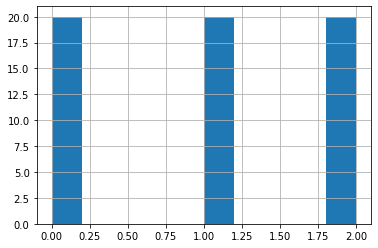

In [20]:
# size of test classes need to be fixed:
test_trgts = []
for _, trgt in testloader: 
    test_trgts+= trgt.tolist()
    
pd.Series(test_trgts).hist()
pd.Series(test_trgts).value_counts()

# Model architecture

In [23]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layer = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(6),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining a 2D convolution layer
            Conv2d(6, 12, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(12),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining a 2D convolution layer
            Conv2d(12, 18, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(18),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining a 2D convolution layer
            Conv2d(18, 36, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(36),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(36 * 14 * 14, 3)
        )
        
        self.lsoftmax = LogSoftmax(dim=1)

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layers(x)
        x = self.lsoftmax(x)
        
        return x

## Cheking forward pass

In [24]:
# ToDo: write asserts 
for ts, _ in trainloader:
    break
    
print(ts.shape)

tmodel = Net()
r = tmodel.forward(ts)
print(r.shape)
print(r)
del ts, _, tmodel, r

torch.Size([5, 3, 224, 224])
torch.Size([5, 3])
tensor([[-1.9413, -1.1773, -0.6008],
        [-1.4104, -1.0427, -0.9077],
        [-1.9513, -1.6649, -0.4024],
        [-1.6153, -1.3647, -0.6057],
        [-1.2727, -1.0926, -0.9556]], grad_fn=<LogSoftmaxBackward0>)


##  Initializing the model and count parametrs 

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {device}')

# Initializing the model
model = Net()

# Defining the optimizer
optimizer = Adam(model.parameters(), lr=0.05)

# defining the loss function
criterion = NLLLoss()

# Checking if GPU is available and place model and criteria on devices
if device == 'cuda':
    model = model.cuda()
    criterion = criterion.cuda()

# Model description
pytorch_total_params =  sum(p.numel() for p in model.parameters())
print(f'Number of params: {pytorch_total_params}')
print(model)

Available device: cpu
Number of params: 29973
Net(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

# Train

In [36]:
epochs = 3
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 26.942.. Test loss: 508.644.. Test accuracy: 0.333
Epoch 1/3.. Train loss: 11.998.. Test loss: 2.790.. Test accuracy: 0.683
Epoch 1/3.. Train loss: 4.350.. Test loss: 0.940.. Test accuracy: 0.800
Epoch 1/3.. Train loss: 0.419.. Test loss: 0.311.. Test accuracy: 0.917
Epoch 2/3.. Train loss: 0.402.. Test loss: 0.381.. Test accuracy: 0.867
Epoch 2/3.. Train loss: 0.486.. Test loss: 0.347.. Test accuracy: 0.833
Epoch 2/3.. Train loss: 0.309.. Test loss: 0.263.. Test accuracy: 0.950
Epoch 2/3.. Train loss: 0.359.. Test loss: 0.247.. Test accuracy: 0.950
Epoch 2/3.. Train loss: 0.369.. Test loss: 0.170.. Test accuracy: 0.917
Epoch 3/3.. Train loss: 0.250.. Test loss: 0.258.. Test accuracy: 0.933
Epoch 3/3.. Train loss: 0.158.. Test loss: 0.196.. Test accuracy: 0.967
Epoch 3/3.. Train loss: 0.081.. Test loss: 0.226.. Test accuracy: 0.950
Epoch 3/3.. Train loss: 0.367.. Test loss: 0.142.. Test accuracy: 0.933
Epoch 3/3.. Train loss: 0.216.. Test loss: 0.140.. Test accu

## Plotting the results

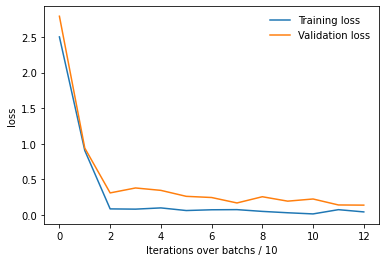

In [44]:
# Skip first pair because difference on Train and Val is so big that plot is not representable..
plt.plot(train_losses[1:], label='Training loss')
plt.plot(test_losses[1:], label='Validation loss')
plt.ylabel('loss')
plt.xlabel('Iterations over batchs / 10')
plt.legend(frameon=False)
plt.show()

# Saving model

In [56]:
torch.save(model.state_dict(), 'train_model_state_dict.pt')

# Inference

In [ ]:
# ToDo device and model required to be function parameters

In [57]:
# In notebook we can simply load the model 
test_transforms = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor(),
    ]
)
# cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
del model
model = Net()
m_state_dict = torch.load('train_model_state_dict.pt')
model.load_state_dict(m_state_dict)
model.eval()

Net(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, tr

In [58]:
def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_ = Variable(image_tensor)
    input_ = input_.to(device)
    output = model(input_)
    index = output.data.cpu().numpy().argmax()
    return index

In [59]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

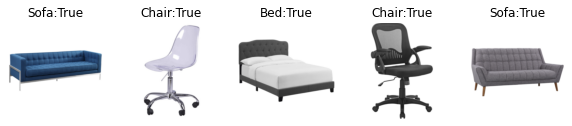

In [61]:
classes = ['Bed', 'Chair', 'Sofa']
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image, model)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()